# Figures

Reproducing the `GQA-paper` figures as described in the `ReadMe.md`.

In [1]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
from collections import Counter
import argparse
from tqdm import tqdm
from scipy.special import rel_entr
import plotly.express as px
import matplotlib.pyplot as plt

In [2]:
show_big_figures = False

## Loading GQA

It takes quiet some time to execute the next cell (on my machine 17min):

In [3]:
gqa_data_path = Path('ver1.2/')

# balanced questions
gqa_train_balanced_questions = pd.DataFrame(json.load(open(Path(gqa_data_path / ('train_' + 'balanced_' + 'questions.json'))))).T
gqa_val_balanced_questions = pd.DataFrame(json.load(open(Path(gqa_data_path / ('val_' + 'balanced_' + 'questions.json'))))).T
gqa_testdev_balanced_questions = pd.DataFrame(json.load(open(Path(gqa_data_path / ('testdev_' + 'balanced_' + 'questions.json'))))).T

gqa_testdev_balanced_questions_test = json.load(open(Path(gqa_data_path / ('testdev_' + 'balanced_' + 'questions.json'))))

# all questions
gqa_train_all_questions_file_paths = [file for file in Path(gqa_data_path / 'train_all_questions').glob('*.json')]
gqa_train_all_questions = pd.DataFrame(json.load(open(gqa_train_all_questions_file_paths[0]))).T
for file in gqa_train_all_questions_file_paths[1:]:
    gqa_train_all_questions = pd.concat([gqa_train_all_questions, pd.DataFrame(json.load(open(file))).T])
gqa_val_all_questions = pd.DataFrame(json.load(open(Path(gqa_data_path / ('val_' + 'all_' + 'questions.json'))))).T
gqa_testdev_all_questions = pd.DataFrame(json.load(open(Path(gqa_data_path / ('testdev_' + 'all_' + 'questions.json'))))).T

gqa_val_all_questions_test = json.load(open(Path(gqa_data_path / ('val_' + 'all_' + 'questions.json'))))

Now concat all the dataframes with the relevant columns, and compute the question length and the semantic composition length.

In [4]:
gqa_train_balanced_questions['datasplit'] = 'train'
gqa_val_balanced_questions['datasplit'] = 'val'
gqa_testdev_balanced_questions['datasplit'] = 'testdev'

gqa_train_all_questions['datasplit'] = 'train'
gqa_val_all_questions['datasplit'] = 'val'
gqa_testdev_all_questions['datasplit'] = 'testdev'

In [36]:
# for balanced:
gqa_questions_balanced_raw = pd.concat([gqa_train_balanced_questions,
                                        gqa_val_balanced_questions,
                                        gqa_testdev_balanced_questions])[['question', 'answer', 'types', 'semantic', 'datasplit', 'groups', 'semanticStr']]

questionIDs_balanced = list(gqa_questions_balanced_raw.index)
gqa_questions_balanced = pd.DataFrame(columns=['questionID', 'question_text', 'answer_text',
                                               'semantic_type', 'structural_type', 'detailed_type', 'datasplit',
                                               'global_question_group', 'local_question_group', 'local_question_group_clean',
                                               'question_length', 'composition_len_semantic'],
                                      index = questionIDs_balanced)

gqa_questions_balanced.loc[slice(None),'questionID'] = gqa_questions_balanced_raw.index.values
gqa_questions_balanced.loc[slice(None),'question_text'] = gqa_questions_balanced_raw['question']
gqa_questions_balanced.loc[slice(None),'answer_text'] = gqa_questions_balanced_raw['answer']
gqa_questions_balanced.loc[slice(None),'semantic_type'] = gqa_questions_balanced_raw['types'].apply(lambda x: x['semantic'])
gqa_questions_balanced.loc[slice(None),'structural_type'] = gqa_questions_balanced_raw['types'].apply(lambda x: x['structural'])
gqa_questions_balanced.loc[slice(None),'detailed_type'] = gqa_questions_balanced_raw['types'].apply(lambda x: x['detailed'])
gqa_questions_balanced.loc[slice(None),'datasplit'] = gqa_questions_balanced_raw['datasplit']

# get balancing stuff
gqa_questions_balanced.loc[slice(None),'global_question_group'] = gqa_questions_balanced_raw['groups'].apply(lambda x: x['global'])
gqa_questions_balanced.loc[slice(None),'local_question_group'] = gqa_questions_balanced_raw['groups'].apply(lambda x: x['local'])

# clean the answer type to fit the paper
gqa_questions_balanced.loc[slice(None),'local_question_group_clean'] = gqa_questions_balanced_raw['groups'].apply(lambda x: x['local'].split('-')[-1].split(',')[0] if type(x['local']) is str else None)

# compute statistics
gqa_questions_balanced.loc[slice(None),'question_length'] = gqa_questions_balanced_raw['question'].apply(lambda x: len(re.findall(r'\w+', x)))
gqa_questions_balanced.loc[slice(None),'question_length_paper'] = gqa_questions_balanced_raw['question'].apply(lambda x: len(x.split())) # following eval.getWordsNum()
gqa_questions_balanced.loc[slice(None),'reasoning_operations'] = gqa_questions_balanced_raw['semanticStr']
gqa_questions_balanced.loc[slice(None),'composition_steps_semantic'] = gqa_questions_balanced_raw['semantic'].apply(lambda x: len(x) -1)

In [37]:
# for all:
gqa_questions_all_raw = pd.concat([gqa_train_all_questions,
                                   gqa_val_all_questions,
                                   gqa_testdev_all_questions])[['question', 'answer', 'types', 'semantic', 'datasplit', 'groups', 'semanticStr']]

questionIDs_all = list(gqa_questions_all_raw.index)
gqa_questions_all = pd.DataFrame(columns=['questionID', 'question_text', 'answer_text',
                                          'semantic_type', 'structural_type', 'detailed_type', 'datasplit',
                                          'global_question_group', 'local_question_group', 'local_question_group_clean',
                                          'question_length', 'composition_len_semantic'],
                                 index = questionIDs_all)

gqa_questions_all.loc[slice(None),'questionID'] = gqa_questions_all_raw.index.values
gqa_questions_all.loc[slice(None),'question_text'] = gqa_questions_all_raw['question']
gqa_questions_all.loc[slice(None),'answer_text'] = gqa_questions_all_raw['answer']
gqa_questions_all.loc[slice(None),'semantic_type'] = gqa_questions_all_raw['types'].apply(lambda x: x['semantic'])
gqa_questions_all.loc[slice(None),'structural_type'] = gqa_questions_all_raw['types'].apply(lambda x: x['structural'])
gqa_questions_all.loc[slice(None),'detailed_type'] = gqa_questions_all_raw['types'].apply(lambda x: x['detailed'])
gqa_questions_all.loc[slice(None),'datasplit'] = gqa_questions_all_raw['datasplit']

# get balancing stuff
gqa_questions_all.loc[slice(None),'global_question_group'] = gqa_questions_all_raw['groups'].apply(lambda x: x['global'])
gqa_questions_all.loc[slice(None),'local_question_group'] = gqa_questions_all_raw['groups'].apply(lambda x: x['local'])

# clean the answer type to fit the paper
gqa_questions_all.loc[slice(None),'local_question_group_clean'] = gqa_questions_all_raw['groups'].apply(lambda x: x['local'].split('-')[-1].split(',')[0] if type(x['local']) is str else None)

# compute statistics
gqa_questions_all.loc[slice(None),'question_length'] = gqa_questions_all_raw['question'].apply(lambda x: len(re.findall(r'\w+', x)))
gqa_questions_all.loc[slice(None),'question_length_paper'] = gqa_questions_all_raw['question'].apply(lambda x: len(x.split()))  # following eval.getWordsNum()
gqa_questions_all.loc[slice(None),'reasoning_operations'] = gqa_questions_all_raw['semanticStr']
gqa_questions_all.loc[slice(None),'composition_steps_semantic'] = gqa_questions_all_raw['semantic'].apply(lambda x: len(x) -1)

In [7]:
gqa_questions_balanced.head(5)

,questionID,question_text,answer_text,semantic_type,structural_type,detailed_type,datasplit,global_question_group,local_question_group,local_question_group_clean,question_length,composition_len_semantic,question_length_paper,reasoning_operations,composition_steps_semantic
02930152,02930152,Is the sky dark?,yes,attr,verify,verifyAttr,train,None,06-sky_dark,sky_dark,4,NaN,4,select: sky (2486325)->verify color: dark [0],1
07333408,07333408,What is on the white wall?,pipe,rel,query,relS,train,,"14-wall_on,s",wall_on,6,NaN,6,select: wall (722332)->filter color: white [0]...,3
07333405,07333405,Is that pipe red?,no,attr,verify,verifyAttrC,train,None,06-pipe_red,pipe_red,4,NaN,4,select: pipe (722335)->verify color: red [0],1
15736264,15736264,Is the tall clock small or large?,large,attr,choose,chooseAttr,train,size,10c-clock_size,clock_size,7,NaN,7,select: clock (746851)->filter height: tall [0...,2
111007521,111007521,Who is wearing a shirt?,girl,rel,query,relS,train,person,"14-shirt_wearing,s",shirt_wearing,5,NaN,5,"select: shirt (4653737)->relate: person,wearin...",2


### Testing the loading

In [8]:
seed = 42

# sample a key from testdev for balanced questions
np.random.seed(seed)
testdev_keys = list(gqa_testdev_balanced_questions_test.keys())
testdev_key = np.random.choice(testdev_keys)

# sample a key from val for all questions
np.random.seed(seed)
val_keys = list(gqa_val_all_questions_test.keys())
val_key = np.random.choice(val_keys)

In [9]:
# balanced
print(f"quid: {testdev_key}")
for key, value in gqa_testdev_balanced_questions_test[testdev_key].items():
    if key == 'semantic':
        for item_ in value:
            print(item_)
    else:
        print(f"{key}: \t {value}")
print("-------------------")
print("How it was loaded:")
gqa_questions_balanced.loc[testdev_key]

quid: 201411119
{'operation': 'select', 'dependencies': [], 'argument': 'clothing (5)'}
{'operation': 'filter color', 'dependencies': [0], 'argument': 'white'}
{'operation': 'query', 'dependencies': [1], 'argument': 'name'}
entailed: 	 ['201411117']
equivalent: 	 ['201411119']
question: 	 Which kind of clothing is white?
imageId: 	 n415215
isBalanced: 	 True
groups: 	 {'global': 'clothing', 'local': '12q-clothing_white'}
answer: 	 shirt
semanticStr: 	 select: clothing (5)->filter color: white [0]->query: name [1]
annotations: 	 {'answer': {'0': '5'}, 'question': {'3': '5'}, 'fullAnswer': {'1': '5', '4': '5'}}
types: 	 {'detailed': 'categoryThat', 'semantic': 'cat', 'structural': 'query'}
fullAnswer: 	 The clothing is a shirt.
-------------------
How it was loaded:


questionID                                           201411119
question_text                 Which kind of clothing is white?
answer_text                                              shirt
semantic_type                                              cat
structural_type                                          query
detailed_type                                     categoryThat
datasplit                                              testdev
global_question_group                                 clothing
local_question_group                        12q-clothing_white
local_question_group_clean                      clothing_white
question_length                                              6
composition_len_semantic                                     3
Name: 201411119, dtype: object

In [10]:
# all
print(f"quid: {val_key}")
for key, value in gqa_val_all_questions_test[val_key].items():
    if key == 'semantic':
        for item_ in value:
            print(item_)
    else:
        print(f"{key}: \t {value}")
print("-------------------")
print("How it was loaded:")
gqa_questions_all.loc[val_key]

quid: 001058327
{'operation': 'select', 'dependencies': [], 'argument': 'bear (1341489)'}
{'operation': 'exist', 'dependencies': [0], 'argument': '?'}
{'operation': 'select', 'dependencies': [], 'argument': 'goat (-) '}
{'operation': 'exist', 'dependencies': [2], 'argument': '?'}
{'operation': 'and', 'dependencies': [1, 3], 'argument': ''}
entailed: 	 ['001058328', '001058329', '001058326']
equivalent: 	 ['001058326', '001058329', '001058327', '001058328']
question: 	 Do you see both bears and goats in the picture?
imageId: 	 2380873
isBalanced: 	 False
groups: 	 {'global': None, 'local': '09existAnd-bear_goat'}
answer: 	 no
semanticStr: 	 select: bear (1341489)->exist: ? [0]->select: goat (-) ->exist: ? [2]->and:  [1, 3]
annotations: 	 {'answer': {}, 'question': {'4': '1341489'}, 'fullAnswer': {'4': '1341489'}}
types: 	 {'detailed': 'existAndC', 'semantic': 'obj', 'structural': 'logical'}
fullAnswer: 	 No, there is a bear but no goats.
-------------------
How it was loaded:


questionID                                                          001058327
question_text                 Do you see both bears and goats in the picture?
answer_text                                                                no
semantic_type                                                             obj
structural_type                                                       logical
detailed_type                                                       existAndC
datasplit                                                                 val
global_question_group                                                    None
local_question_group                                     09existAnd-bear_goat
local_question_group_clean                                          bear_goat
question_length                                                            10
composition_len_semantic                                                    5
Name: 001058327, dtype: object

## Reproducing figure 7: First Question Words (ReadMe: 1.)

To reduce the elements which need to be plotted, I introduce a cutoff of 0.1% of the total number questions for each word to be plotted. If it is below the cutoff, an `null` is plotted. This is not perfect, but suffices.

In [13]:
# create a dataframe for the sunburst diagram: first words, then their corresponding value up to a cut-off
# the cut-off is 0.1% of the total number of questions

# extract the first four words from the question_text
gqa_questions_balanced['first_four_words'] = gqa_questions_balanced['question_text'].str.split().apply(lambda x: ' '.join(x[:4]))

# remove the question marks at the end and lower case
gqa_questions_balanced['first_four_words'] = gqa_questions_balanced['first_four_words'].str.replace('?', '')
gqa_questions_balanced['first_four_words'] = gqa_questions_balanced['first_four_words'].str.lower()

# sum up duplicate 'first_four_words' and then drop the duplicates / count occurences
word_counts = gqa_questions_balanced['first_four_words'].value_counts().reset_index()
word_counts.columns = ['first_four_words', 'count']

print(f"The count sum of all words is: {word_counts['count'].sum()}")

word_counts

The count sum of all words is: 1087640


,first_four_words,count
0,on which side of,26448
1,what color is the,20508
2,what is on the,16206
3,on which side is,13730
4,do you see any,13531
...,...,...
61089,is the comforter red,1
61090,what watercraft is grouped,1
61091,who drives a cart,1
61092,the arrow is printed,1


In [14]:
# create a new dataframe with the necessary info
sunburst_df = pd.DataFrame(columns=['first_words', 'second_words', 'third_words', 'fourth_words', 'count'])

print(f"The minimum length of the questions is {gqa_questions_balanced['question_length'].min()} and the maximum length is {gqa_questions_balanced['question_length'].max()}")

# split the question into its words
sunburst_df['first_words'] = word_counts['first_four_words'].apply(lambda x: x.split()[0])
sunburst_df['second_words'] = word_counts['first_four_words'].apply(lambda x: x.split()[1])
sunburst_df['third_words'] = word_counts['first_four_words'].apply(lambda x: x.split()[2])
sunburst_df['fourth_words'] = word_counts['first_four_words'].apply(lambda x: x.split()[3] if len(x.split()) >= 4  else "null")

# remove the question mark for the third_word and the forth_word
# sunburst_df['third_words'] = sunburst_df['third_words'].apply(lambda x: x[:-1] if x[-1] == '?' else x)
# sunburst_df['fourth_words'] = sunburst_df['fourth_words'].apply(lambda x: x[:-1] if x != "" and x[-1] == '?' else x)

sunburst_df['count'] = word_counts['count']

print(f"Check: The sunburst diagram dataframe has {sunburst_df.shape[0]} entries with a count sum of {sunburst_df['count'].sum()}")

The minimum length of the questions is 3 and the maximum length is 28
Check: The sunburst diagram dataframe has 61094 entries with a count sum of 1087640


In [15]:
# check:
for index, row in sunburst_df.iterrows():
    if row['fourth_words'] != "null":
        reconstructed_question = " ".join([row['first_words'], row['second_words'], row['third_words'], row['fourth_words']])
        reconstructed_question_mark = reconstructed_question+"?"
        if reconstructed_question in word_counts['first_four_words'].values:
            idx = word_counts['first_four_words'].tolist().index(reconstructed_question)
            if word_counts.iloc[idx]['count'] != row['count']:
                print(f"Count mismatch for {reconstructed_question}: {word_counts.iloc[idx]['count']} vs. {row['count']}")
        elif reconstructed_question_mark in word_counts['first_four_words'].values:
            idx = word_counts['first_four_words'].tolist().index(reconstructed_question_mark)
            if word_counts.iloc[idx]['count'] != row['count']:
                print(f"Count mismatch for {reconstructed_question}: {word_counts.iloc[idx]['count']} vs. {row['count']}")
        else:
            print(f"Question {reconstructed_question} not found in the word_counts dataframe")

In [16]:
cutoff = 0.001 * len(gqa_questions_balanced)
sunburst_df_reduced = sunburst_df.copy()

# set the fourth_word to None if the count is below the cutoff
sunburst_df_reduced.loc[sunburst_df_reduced['count'] < cutoff, 'fourth_words'] = "null"
# "null" workaround because of https://github.com/plotly/plotly.py/issues/3589

# aggregate the count of the duplicate entries (resulting from the cutoff) and drop the duplicates
sunburst_df_reduced = sunburst_df_reduced.groupby(['first_words', 'second_words', 'third_words', 'fourth_words'])['count'].sum().reset_index()
sunburst_df_reduced.drop_duplicates(inplace=True, keep='first')
print(f"Check: The sunburst diagram dataframe has {len(sunburst_df_reduced)} entries with a count sum of {sunburst_df_reduced['count'].sum()}")

# set the third_word to None if the fourth_word is None and the count still below the cutoff
sunburst_df_reduced.loc[(sunburst_df_reduced['fourth_words'] == "null") & (sunburst_df_reduced['count'] < cutoff), 'third_words'] = "null"

# aggregate the count of the duplicate entries (resulting from the cutoff) and drop the duplicates
sunburst_df_reduced = sunburst_df_reduced.groupby(['first_words', 'second_words', 'third_words', 'fourth_words'])['count'].sum().reset_index()
sunburst_df_reduced.drop_duplicates(inplace=True, keep='first')
print(f"Check: The sunburst diagram dataframe has {len(sunburst_df_reduced)} entries with a count sum of {sunburst_df_reduced['count'].sum()}")

# set the second_word to None if the third_word is None and the count still below the cutoff
sunburst_df_reduced.loc[(sunburst_df_reduced['third_words'] == "null") & (sunburst_df_reduced['count'] < cutoff), 'second_words'] = "null"

# aggregate the count of the duplicate entries (resulting from the cutoff) and drop the duplicates
sunburst_df_reduced = sunburst_df_reduced.groupby(['first_words', 'second_words', 'third_words', 'fourth_words'])['count'].sum().reset_index()
sunburst_df_reduced.drop_duplicates(inplace=True, keep='first')
print(f"Check: The sunburst diagram dataframe has {len(sunburst_df_reduced)} entries with a count sum of {sunburst_df_reduced['count'].sum()}")

# set the first_word to None if the second_word is None and the count still below the cutoff
sunburst_df_reduced.loc[(sunburst_df_reduced['second_words'] == "null") & (sunburst_df_reduced['count'] < cutoff), 'first_words'] = "null"

# aggregate the count of the duplicate entries (resulting from the cutoff) and drop the duplicates
sunburst_df_reduced = sunburst_df_reduced.groupby(['first_words', 'second_words', 'third_words', 'fourth_words'])['count'].sum().reset_index()
sunburst_df_reduced.drop_duplicates(inplace=True, keep='first')
print(f"Check: The sunburst diagram dataframe has {len(sunburst_df_reduced)} entries with a count sum of {sunburst_df_reduced['count'].sum()}")

sunburst_df_reduced

Check: The sunburst diagram dataframe has 13354 entries with a count sum of 1087640
Check: The sunburst diagram dataframe has 2216 entries with a count sum of 1087640
Check: The sunburst diagram dataframe has 250 entries with a count sum of 1087640
Check: The sunburst diagram dataframe has 214 entries with a count sum of 1087640


,first_words,second_words,third_words,fourth_words,count
0,are,both,the,null,2625
1,are,the,null,null,18999
2,are,there,any,men,1176
3,are,there,any,null,32923
4,are,there,any,people,1091
...,...,...,...,...,...
209,who,is,wearing,null,5254
210,who,is,wearing,the,11118
211,who,null,null,null,4073
212,who,wears,a,null,1856


In [17]:
# check:
for index, row in sunburst_df_reduced.iterrows():
    if row['fourth_words'] != "null":
        reconstructed_question = " ".join([row['first_words'], row['second_words'], row['third_words'], row['fourth_words']])
        reconstructed_question_mark = reconstructed_question+"?"
        if reconstructed_question in word_counts['first_four_words'].values:
            idx = word_counts['first_four_words'].tolist().index(reconstructed_question)
            if word_counts.iloc[idx]['count'] != row['count']:
                print(f"Count mismatch for {reconstructed_question}: {word_counts.iloc[idx]['count']} vs. {row['count']}")
        elif reconstructed_question_mark in word_counts['first_four_words'].values:
            idx = word_counts['first_four_words'].tolist().index(reconstructed_question_mark)
            if word_counts.iloc[idx]['count'] != row['count']:
                print(f"Count mismatch for {reconstructed_question}: {word_counts.iloc[idx]['count']} vs. {row['count']}")
        else:
            print(f"Question {reconstructed_question} not found in the word_counts dataframe")

In [42]:
# for all values below the cutoff, go even back further and sum up the counts for the first two words
fig = px.sunburst(sunburst_df_reduced, path=['first_words', 'second_words', 'third_words', 'fourth_words'], values='count')
fig.write_html('results/fig7_sunburst.html')
fig.write_image('results/fig7_sunburst.png')
if show_big_figures:
    fig.show()  # increases the size of the notebook much, open in results/

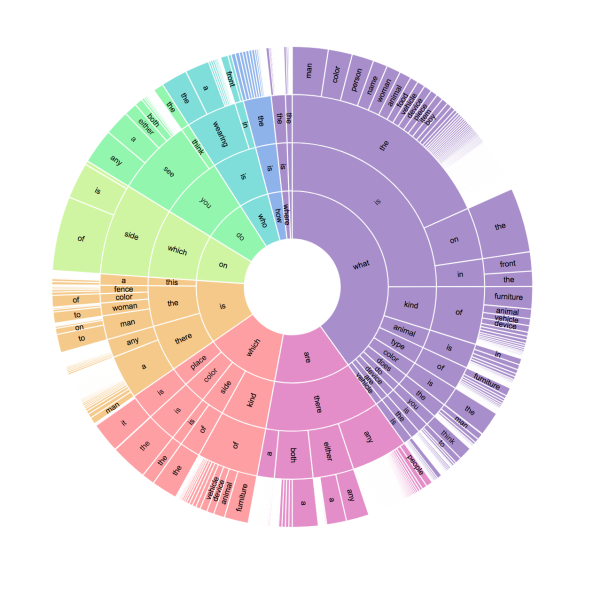

My figure is super different:

* `what` is much less predominant
* `what is the` is followed most often by `color` instead of `man`
* `are` is also followed by `the` not only `there`
* `is` is followed by 4.5x as many `the` as `there`
* `is` is also followed by `that`, not only `there`, `the`, `this`
* ...

### Check whether it could be the data split

In [19]:
gqa_questions_balanced[(gqa_questions_balanced['question_text'].str.contains('Are the ')) & (gqa_questions_balanced['datasplit'] == 'train')]

,questionID,question_text,answer_text,semantic_type,structural_type,detailed_type,datasplit,global_question_group,local_question_group,local_question_group_clean,question_length,composition_len_semantic,first_four_words
131056308,131056308,Are the kids on the rock?,yes,rel,verify,relVerify,train,None,13-children_rock,children_rock,6,2,are the kids on
16378562,16378562,Are the ripe bananas above a newspaper?,yes,rel,verify,relVerify,train,None,13-bananas_newspaper,bananas_newspaper,7,3,are the ripe bananas
10138194,10138194,Are the feathers yellow or blue?,yellow,attr,choose,chooseAttr,train,color,10c-feathers_color,feathers_color,6,2,are the feathers yellow
06269159,06269159,Are the fries on a tray?,yes,rel,verify,relVerify,train,None,13-fries_tray,fries_tray,6,2,are the fries on
18207337,18207337,Are the people in the field standing by a lamb?,no,rel,verify,relVerifyCo,train,None,13-people_lamb,people_lamb,10,3,are the people in
...,...,...,...,...,...,...,...,...,...,...,...,...,...
09763531,09763531,Are the cups to the right or to the left of th...,right,rel,choose,relChooser,train,None,13-person_cups,person_cups,13,2,are the cups to
11908303,11908303,Are the boxes of vegetables on the left side o...,right,attr,choose,positionChoose,train,None,10c-boxes_hposition,boxes_hposition,16,3,are the boxes of
14437265,14437265,Are the candies to the left of a DVD player?,no,rel,verify,relVerifyCo,train,None,13-candies_dvd player,candies_dvd player,10,2,are the candies to
14720671,14720671,Are the person's eyes large and brown?,yes,attr,logical,verifyAttrs,train,None,05-brown_large,brown_large,8,5,are the person's eyes


In [20]:
gqa_questions_balanced[(gqa_questions_balanced['question_text'].str.contains('Are the ')) & (gqa_questions_balanced['datasplit'] == 'val')]

,questionID,question_text,answer_text,semantic_type,structural_type,detailed_type,datasplit,global_question_group,local_question_group,local_question_group_clean,question_length,composition_len_semantic,first_four_words
08203407,08203407,Are the curtains to the right or to the left o...,right,rel,choose,relChooser,val,None,13-pillow_curtains,pillow_curtains,14,3,are the curtains to
12661982,12661982,Are the shorts black or green?,black,attr,choose,chooseAttr,val,color,10c-shorts_color,shorts_color,6,2,are the shorts black
14311593,14311593,Are the letters on the bag on the left?,yes,rel,verify,relVerify,val,None,13-letters_bag,letters_bag,9,2,are the letters on
00457871,00457871,Are the glasses on a couch?,no,rel,verify,relVerifyCo,val,None,13-glasses_couch,glasses_couch,6,2,are the glasses on
01109297,01109297,Are the glasses in the bottom part or in the top?,top,attr,choose,positionChoose,val,None,10c-glasses_vposition,glasses_vposition,11,2,are the glasses in
...,...,...,...,...,...,...,...,...,...,...,...,...,...
01705920,01705920,Are the cabinets in the top of the image?,yes,attr,verify,positionVerify,val,None,06-cabinets_top,cabinets_top,9,2,are the cabinets in
16652856,16652856,Are the frame and the nightstand made of the s...,yes,attr,compare,twoSameMaterial,val,None,09same-frame_nightstand,frame_nightstand,11,3,are the frame and
011020859,011020859,Are the shirt and the frame the same color?,no,attr,compare,twoSameC,val,None,09same-frame_shirt,frame_shirt,9,3,are the shirt and
09298940,09298940,Are the letters blue or black?,black,attr,choose,chooseAttr,val,color,10c-letters_color,letters_color,6,2,are the letters blue


### Testing the Sunburst Calculations

In [21]:
# check: whether `what is the` is followed most often by `color` (supplemental) or `man`
print("Is 'color' more frequent than 'man' for 'what is the'?")
print(f"'What is the' is followed by 'color' in {gqa_questions_balanced[gqa_questions_balanced['question_text'].str.contains('What is the color ')]['questionID'].count()} questions, and the sunburst says {sunburst_df_reduced[(sunburst_df_reduced['first_words'] == 'what') &  (sunburst_df_reduced['second_words'] == 'is') & (sunburst_df_reduced['third_words'] == 'the') & (sunburst_df_reduced['fourth_words'] == 'color')]['count'].values[0]} questions.")
print(f"'What is the' is followed by 'man' in {gqa_questions_balanced[gqa_questions_balanced['question_text'].str.contains('What is the man ')]['questionID'].count()} questions, and the sunburst says {sunburst_df_reduced[(sunburst_df_reduced['first_words'] == 'what') &  (sunburst_df_reduced['second_words'] == 'is') & (sunburst_df_reduced['third_words'] == 'the') & (sunburst_df_reduced['fourth_words'] == 'man')]['count'].values[0]} questions.")
print(f"With the question mark it would be {gqa_questions_balanced[gqa_questions_balanced['question_text'].str.contains('What is the man |What is the man?', regex=True)]['questionID'].count()} and {gqa_questions_balanced[gqa_questions_balanced['question_text'].str.contains('What is the color |What is the color?', regex=True)]['questionID'].count()}, respectively.")

# check: whether all `are` are followed by `there` or also by `the`
print("\nIs there also 'the' after 'are'?")
print(f"'Are' is followed by 'there' in {gqa_questions_balanced[gqa_questions_balanced['question_text'].str.contains('Are there ')]['questionID'].count()} questions, and the sunburst says {sum(sunburst_df_reduced[(sunburst_df_reduced['first_words'] == 'are') &  (sunburst_df_reduced['second_words'] == 'there')]['count'])} questions.")
print(f"'Are' is followed by 'the' in {gqa_questions_balanced[gqa_questions_balanced['question_text'].str.contains('Are the ')]['questionID'].count()} questions, and the sunburst says {sum(sunburst_df_reduced[(sunburst_df_reduced['first_words'] == 'are') &  (sunburst_df_reduced['second_words'] == 'the')]['count'])} questions.")

# check: whether `is` is followed by 4.5x as many `the` as `there`, or that `there` is more frequent
print("\nIs 'the' more frequent than 'there' for 'is'?")
print(f"'Is' is followed by 'the' in {gqa_questions_balanced[gqa_questions_balanced['question_text'].str.contains('Is the ')]['questionID'].count()} questions, and the sunburst says {sum(sunburst_df_reduced[(sunburst_df_reduced['first_words'] == 'is') &  (sunburst_df_reduced['second_words'] == 'the')]['count'])} questions.")
print(f"'Is' is followed by 'there' in {gqa_questions_balanced[gqa_questions_balanced['question_text'].str.contains('Is there ')]['questionID'].count()} questions, and the sunburst says {sum(sunburst_df_reduced[(sunburst_df_reduced['first_words'] == 'is') &  (sunburst_df_reduced['second_words'] == 'there')]['count'])} questions.")

# check: whether `is` is also followed by `that`
print("\nIs there also 'that' also after 'is'?")
print(f"'Is' is followed by 'that' in {gqa_questions_balanced[gqa_questions_balanced['question_text'].str.contains('Is that ')]['questionID'].count()} questions, and the sunburst says {sum(sunburst_df_reduced[(sunburst_df_reduced['first_words'] == 'is') &  (sunburst_df_reduced['second_words'] == 'that')]['count'])} questions.")

Is 'color' more frequent than 'man' for 'what is the'?
'What is the' is followed by 'color' in 13055 questions, and the sunburst says 13055 questions.
'What is the' is followed by 'man' in 9690 questions, and the sunburst says 9690 questions.
With the question mark it would be 10129 and 13079, respectively.

Is there also 'the' after 'are'?
'Are' is followed by 'there' in 106116 questions, and the sunburst says 106116 questions.
'Are' is followed by 'the' in 18999 questions, and the sunburst says 18999 questions.

Is 'the' more frequent than 'there' for 'is'?
'Is' is followed by 'the' in 184796 questions, and the sunburst says 184796 questions.
'Is' is followed by 'there' in 42347 questions, and the sunburst says 41401 questions.

Is there also 'that' also after 'is'?
'Is' is followed by 'that' in 5114 questions, and the sunburst says 5114 questions.


Okay, it's not all perfect, but close enough.

Okay, where are the differences in my code?

In [22]:
# plausibilty check whether the above is also in the gqa_train_balanced_questions w/o any modifications
problematic_keys = list(gqa_questions_balanced[(gqa_questions_balanced['question_text'].str.contains('Are the ')) & (gqa_questions_balanced['datasplit'] == 'val')]['questionID'])
for key, item in gqa_val_balanced_questions.items():
    if key in problematic_keys:
        if not item['question'] == gqa_questions_balanced.loc[key]['question_text']:
            print(f"There is sth with {key} and {item['question']} and {gqa_questions_balanced.loc[key]['question_text']}")
print("DONE")

DONE


## Reproducing figure 8: Ratio Types (ReadMe: 2.)

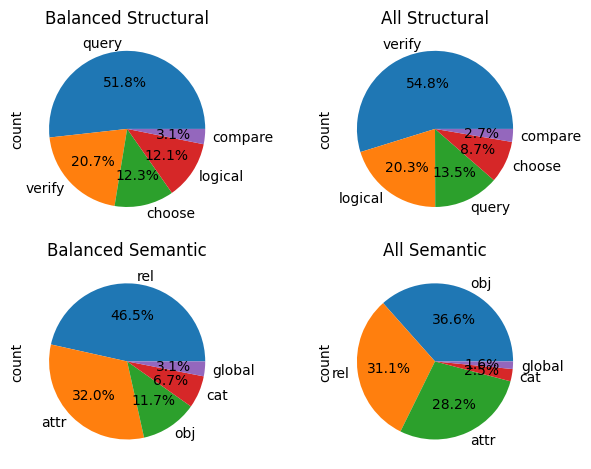

In [23]:
# visualize the type distributions
# with a 2x2 grid of pie charts, on the y-axis the type (structural, semantic) and on the x-axis the dataset (balanced, all)
fig, axs = plt.subplots(2, 2)

gqa_questions_balanced['structural_type'].value_counts().plot.pie(ax=axs[0,0],autopct='%1.1f%%')
axs[0,0].set_title('Balanced Structural')

gqa_questions_balanced['semantic_type'].value_counts().plot.pie(ax=axs[1,0],autopct='%1.1f%%')
axs[1,0].set_title('Balanced Semantic')

gqa_questions_all['structural_type'].value_counts().plot.pie(ax=axs[0,1],autopct='%1.1f%%')
axs[0,1].set_title('All Structural')

gqa_questions_all['semantic_type'].value_counts().plot.pie(ax=axs[1,1],autopct='%1.1f%%')
axs[1,1].set_title('All Semantic')

plt.tight_layout()
# write to file
plt.savefig('results/fig8_GQA_types.png')
plt.show()

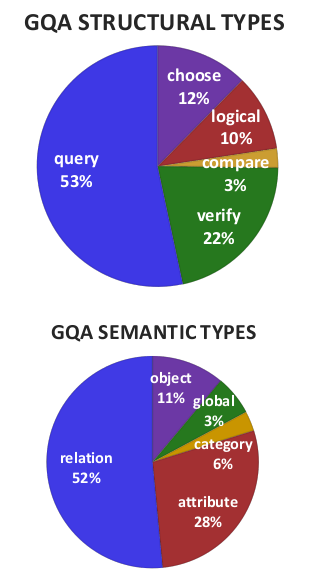

structural
* query: $51.7 \% != 53 \%$
* verify: $20.7 \% != 22 \%$
* logical: $12.1 \% != 10 \%$

semantic:
* relation: $46.6 \% != 52 \%$
* object: $11.8 \% != 11 \%$
* category: $6.7 \% != 6 \%$
* attribute: $31.9 \% != 28 \%$

Maybe it changes significantly if a different datasplit is used (only for balanced):

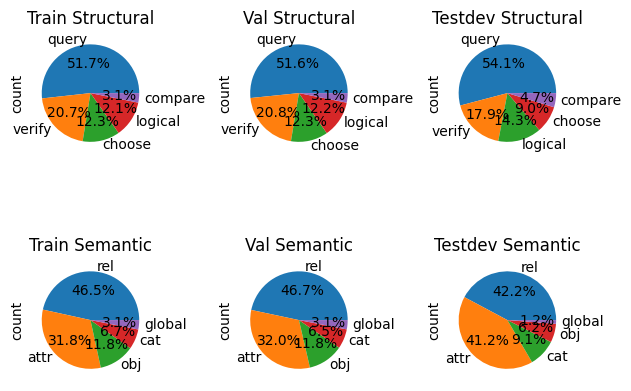

In [24]:
# visualize the type distributions, for balanced only
# with a 3x2 grid of pie charts, on the y-axis the type (structural, semantic) and on the x-axis the data split (train, val, testdev)
fig, axs = plt.subplots(2, 3)

gqa_questions_balanced[gqa_questions_balanced['datasplit'] == 'train']['structural_type'].value_counts().plot.pie(ax=axs[0,0],autopct='%1.1f%%')
axs[0,0].set_title('Train Structural')

gqa_questions_balanced[gqa_questions_balanced['datasplit'] == 'train']['semantic_type'].value_counts().plot.pie(ax=axs[1,0],autopct='%1.1f%%')
axs[1,0].set_title('Train Semantic')

gqa_questions_balanced[gqa_questions_balanced['datasplit'] == 'val']['structural_type'].value_counts().plot.pie(ax=axs[0,1],autopct='%1.1f%%')
axs[0,1].set_title('Val Structural')

gqa_questions_balanced[gqa_questions_balanced['datasplit'] == 'val']['semantic_type'].value_counts().plot.pie(ax=axs[1,1],autopct='%1.1f%%')
axs[1,1].set_title('Val Semantic')

gqa_questions_balanced[gqa_questions_balanced['datasplit'] == 'testdev']['structural_type'].value_counts().plot.pie(ax=axs[0,2],autopct='%1.1f%%')
axs[0,2].set_title('Testdev Structural')

gqa_questions_balanced[gqa_questions_balanced['datasplit'] == 'testdev']['semantic_type'].value_counts().plot.pie(ax=axs[1,2],autopct='%1.1f%%')
axs[1,2].set_title('Testdev Semantic')

plt.tight_layout()
plt.show()

There seems to be quiet a bit of variance in it, but is it really enough to change the picture if the train data split has much more samples?

## Reproducing table 2: Function Catalog (ReadMe: 3.)

The type of the function catalog is encoded in the string before the `local_question_group`/ the `-` and the encoding takes place in `getConditional()`. We can reconstruct the `type` by reversing that mapping:

In [8]:
conditional2type = {  # categories of the used codes
    '01': 'verifyState',  # state, attribute
    '02c': 'chooseState',  # state
    '02q': 'queryState',  # state
    '03': ["existT", "existF"],  # object
    '04': [{'n#': "existNot"}, "existAttr"],  # not is directly after the -
    '05': ["verifyAttrsT", "verifyAttrsF"],  # attribute, attribute
    '06': ["verifyAttrT", "verifyAttrF"],  # object, attribute
    '07same': 'allSame',  # "all"
    '07different': 'allDifferent',  # "all"
    '08oc': 'objThisChoose',  # object, object
    # complex logic, reconstruced with paper; object, object:
    '09common': "common",
    '09compare': "compare",
    '09diff': "twoDiff",  # also all? but allDifferent would have returned earlier
    '09existAnd': "logicAnd",
    '09existOr': "logicOr",
    '09same': "twoSame",  # also all? but allSame would have returned earlier
    '09verifyAttrAnd': "verifyAttrs",
    '10c': "chooseAttr",  # object, state
    '10q': "queryAttr",  # object, state
    '11c': "categoryThisChoose",  # category
    '11q': ["category", "categoryThis"],  # category
    '12c': "categoryThatChoose",  # category, attribute(+not) aka n#
    '12q': ["categoryAttr", "categoryThat"],  # category, attribute(+not) aka n#
    '13': ["verifyRelT", "existRelT", "verifyRelF", "existRelF", "chooseRel"], # object, object
    '14': ["relS", "relO", "sameRelate", "sameMaterialRelate"],  # object, relation
    '15': "categoryRel",
    # if it's none of the above, it's "activityWho": result of question2act: act
}

There is ambigiuity in `verifyAttrs`, `exist` as sometimes it has a `T`, `F` postfix

In [39]:
# get all the prefixes
gqa_questions_all['type_prefix'] = gqa_questions_all_raw['groups'].apply(lambda x: x['local'].split('-')[0] if type(x['local']) is str else None)
gqa_questions_balanced['type_prefix'] = gqa_questions_balanced_raw['groups'].apply(lambda x: x['local'].split('-')[0] if type(x['local']) is str else None)

prefixes = set(gqa_questions_all['type_prefix'].values)
prefixes

{'01',
 '02c',
 '02q',
 '03',
 '04',
 '05',
 '06',
 '07different',
 '07same',
 '08oc',
 '09common',
 '09compare',
 '09diff',
 '09existAnd',
 '09existOr',
 '09same',
 '09verifyAttrAnd',
 '10c',
 '10q',
 '11c',
 '11q',
 '12c',
 '12q',
 '13',
 '14',
 '15',
 None,
 'bending',
 'brushing teeth',
 'cast on shadow',
 'cooking',
 'crouching',
 'dressed in beige',
 'dressed in black',
 'dressed in blue',
 'dressed in brown',
 'dressed in gold',
 'dressed in gray',
 'dressed in green',
 'dressed in khaki',
 'dressed in light blue',
 'dressed in maroon',
 'dressed in orange',
 'dressed in pink',
 'dressed in purple',
 'dressed in red',
 'dressed in tan',
 'dressed in white',
 'dressed in yellow',
 'drinking',
 'driving',
 'eating',
 'facing away',
 'facing front',
 'facing left',
 'facing right',
 'jumping',
 'looking ahead',
 'looking at the camera',
 'looking away',
 'looking back',
 'looking behind',
 'looking down',
 'looking downward',
 'looking for a wave',
 'looking for fish',
 'looking fo

That fits the above now.

In [40]:
# matching function
def matching_type(row):  # TODO fix
    """
    Match the prefix to the type of the question with the conditional2type dictionary.
    """
    if row['type_prefix'] in conditional2type.keys():
        if row['type_prefix'] != '04':
            return conditional2type[row['type_prefix']]
        else:
            if list(conditional2type['04'][0].keys())[0] in row['local_question_group']:
                return list(conditional2type['04'][0].values())[0]
            else:
                return conditional2type['04'][1]
    else:
        return None

# do the matching
gqa_questions_all['type'] = gqa_questions_all.apply(matching_type, axis='columns')
gqa_questions_balanced['type'] = gqa_questions_balanced.apply(matching_type, axis='columns')

# get the unambigious cases
gqa_questions_all['distinct_type'] = gqa_questions_all['type'].apply(lambda x: x if type(x) is str else None)
gqa_questions_balanced['distinct_type'] = gqa_questions_balanced['type'].apply(lambda x: x if type(x) is str else None)

In [41]:
# check if it worked
gqa_questions_all[['type', 'type_prefix', 'distinct_type']].sample(15)

,type,type_prefix,distinct_type
13150291,logicOr,09existOr,logicOr
14937307,logicOr,09existOr,logicOr
121003188,"[existT, existF]",03,None
05246642,logicOr,09existOr,logicOr
02389475,"[existT, existF]",03,None
00998435,"[verifyAttrT, verifyAttrF]",06,None
1845568,logicAnd,09existAnd,logicAnd
07447235,"[existT, existF]",03,None
04777313,"[verifyRelT, existRelT, verifyRelF, existRelF,...",13,None
08696011,logicOr,09existOr,logicOr


In [42]:
gqa_question_stats_table = gqa_questions_all[['distinct_type', 'semantic_type', 'structural_type']].drop_duplicates()

# sort values by semantic_type in the order: 'global', 'attribute', 'category', 'relation', 'object'
print(f"The unique values of the semantic_type are {gqa_question_stats_table['semantic_type'].unique()}")
gqa_question_stats_table['semantic_type'] = pd.Categorical(gqa_question_stats_table['semantic_type'], categories=['global', 'attr', 'cat', 'rel', 'obj'], ordered=True)
gqa_question_stats_table = gqa_question_stats_table.sort_values(by='semantic_type')

# write to file
gqa_question_stats_table.to_csv('results/tab2_functions_catalog.csv', index=False)

gqa_question_stats_table

The unique values of the semantic_type are ['obj' 'attr' 'rel' 'cat' 'global']


,distinct_type,semantic_type,structural_type
0522647,verifyState,global,verify
0522646,queryState,global,query
09953385,chooseState,global,choose
18738205,None,attr,choose
08519870,None,attr,verify
08519871,queryAttr,attr,query
02915764,compare,attr,compare
081012685,common,attr,compare
10572050,None,attr,logical
07404208,chooseAttr,attr,choose


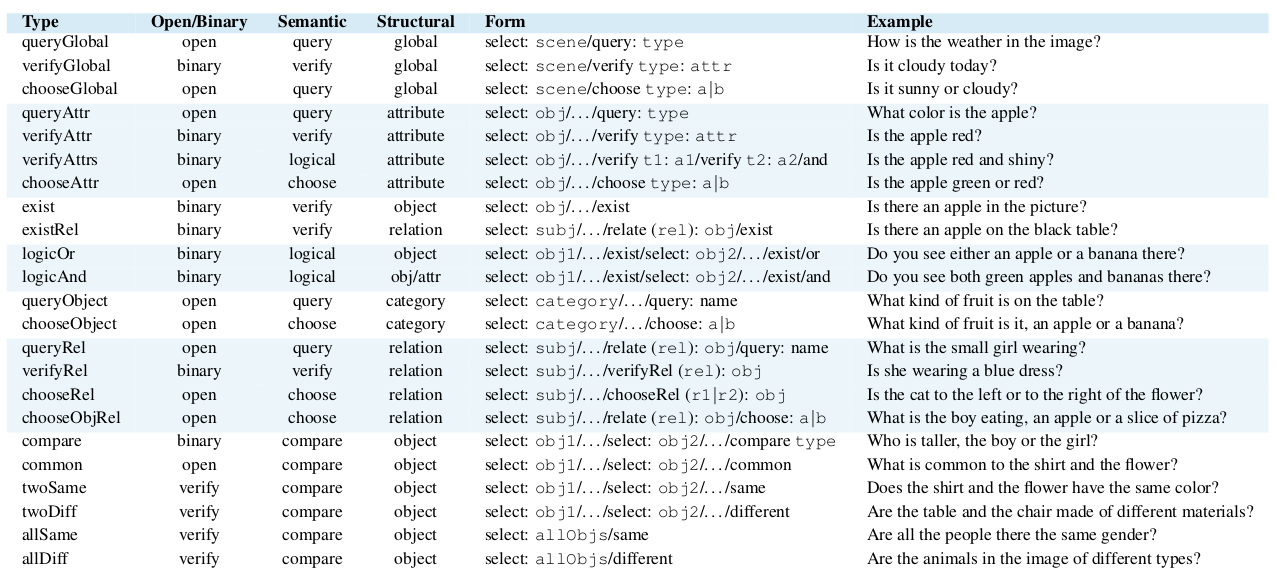

Clearly, `semantic` and `structural` is switched. Differences in:

* `chooseGlobal`/`chooseState`: `choose` instead of `query`
* `compare`, `common`, `twoSame`, `twoDiff`, `allSame`, `allDiff`: `attr` instead of `object`

`verifyAttrs` does not make sense in my code, maybe it's because of the unclear postfixes.

Plot `fig. 7b` only with the questions where the matching of their type was clear:

In [43]:
# make a pie diagram with all values of detailed_type in gqa_question_stats with plotly and interactive
fig = px.pie(gqa_questions_balanced, names='distinct_type')

# the legend should only show the first 20 entries and be on the left
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(showlegend=False, legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))

fig.write_image('results/fig7b_question_type_pie.png')
if show_big_figures:
    fig.show()  # too big to show in the notebook

## Reproducing figure 10: Dataset Balancing (ReadMe: 4.)

As one can see that the downsampling is done on the level of `cond = getConditional(instance, question)`, this code now does not use the "cleaned" (or paper-like version) of the local groups, but matches the normalized versions from the paper to the supposed original conditionals.

In [8]:
# unique values
global_question_group_set = set(gqa_questions_balanced['global_question_group'])
local_question_group_clean_set = set(gqa_questions_balanced['local_question_group_clean'])
local_question_group_set = set(gqa_questions_balanced['local_question_group'])

print(f"There are {len(list(global_question_group_set))} global question groups")
print(f"There are {len(list(set(gqa_questions_balanced['local_question_group'])))} local question groups, after cleaning there are {len(list(local_question_group_clean_set))} local question groups")

There are 117 global question groups
There are 148149 local question groups, after cleaning there are 116145 local question groups


In [9]:
global_question_types_in_paper = ['length', 'height', 'size', 'fast food', 'aircraft', 'bag', 'watercraft', 'person', 'room', 'weather', 'appliance', 'baked good',
                                  'thing', 'road', 'vehicle', 'fruit', 'place', 'dessert', 'urban environment', 'pose', 'furniture', 'activity', 'animal', 'food',
                                  'color', 'vegetable', 'material', 'clothing', 'device', 'object']
local_question_types_in_paper = ['car_vposition', 'hair_length', 'location', 'girl_age', 'bottle_material', 'window_size', 'woman_hposition', 'grass_height', 
                                 'shirt_pattern', 'clock', 'floor_cleanliness', 'man', 'location_outdoors', 'car_modernity', 'plate_shape', 'sky_color', 'dog_color',
                                 'man_woman', 'water_state', 'table_material', 'apple_color', 'pizza_cooking', 'ground_type', 'fence_material', 'sky_weather',
                                 'man_sportActivity', 'shirt_color','trees_leafy', 'man_pose', 'man_activity']

In [10]:
local_question_group_set.remove(None)

# get all local conditionals similar to the ones in the paper and write them to a file
with open('results/local_types2conditionals.txt', 'w') as f:
    for local_group in local_question_types_in_paper:
        f.write(f"\nLOCAL GROUP: {local_group}\n")
        for local_group2 in local_question_group_set:
            if local_group in local_group2:
                f.write(f"Found: {local_group2}\n")

In [12]:
matched_local_question_types_2_conditional = {
    'car_vposition': '10c-car_vposition',
    'hair_length': ['10q-hair_length', '10c-hair_length'],
    'location': '02c-location',
    'girl_age': ['10q-girl_age', '10c-girl_age'],
    'bottle_material': ['10q-bottle_material', '10c-bottle_material'],
    'window_size': ['10q-window_size', '10c-window_size'],
    'woman_hposition': ['10q-woman_hposition', '10c-woman_hposition'],
    'grass_height': ['10q-grass_height', '10c-grass_height'],
    'shirt_pattern': ['10q-shirt_pattern', '10c-shirt_pattern'],
    'clock': '03-clock',  # ~1000 clocks, hard to be sure
    'floor_cleanliness': ['10q-floor_cleanliness', '10c-floor_cleanliness'],
    'man': None,  # ~4000 man, but none man really fits!
    'location_outdoors': '01-location_outdoors',
    'car_modernity': None,
    'plate_shape': ['10q-plate_shape', '10c-plate_shape'],
    'sky_color': ['10q-sky_color', '10c-sky_color'],
    'dog_color': ['10q-dog_color', '10c-dog_color'],
    'man_woman': ['09existOr-man_woman', '09existAnd-man_woman', '13-man_woman', '09compare-man_woman'],
    'water_state': ['10q-water_state', '10c-water_state'],
    'table_material': ['10q-table_material', '10c-table_material'],
    'apple_color': ['10q-apple_color','10c-apple_color'],
    'pizza_cooking': ['14-pizza_cooking,s', '06-pizza_cooking'],
    'ground_type': None,
    'fence_material': ['10q-fence_material', '10c-fence_material'],
    'sky_weather': '10c-sky_weather',
    'man_sportActivity': ['10q-man_sportActivity', '10c-man_sportActivity'],
    'shirt_color': ['10q-shirt_color', '10c-shirt_color'],
    'trees_leafy': '06-trees_leafy',
    'man_pose': ['10q-man_pose', '10c-man_pose'],
    'man_activity': ['10q-man_activity', '10c-man_activity'],
}

There is a great amout of ambiguity in the matching. Especially because of the `10` questions with `q` for "queryAttr" and `c` for "chooseAttr".

In [10]:
# check whether the reported answer types are in the respective set
for answer in global_question_types_in_paper:
    if answer not in global_question_group_set:
        print(f"{answer} is not in the global set")

# otherwise there are problems in the loop
if None in local_question_group_clean_set:
    local_question_group_clean_set.remove(None)

for answer in local_question_types_in_paper:
    if answer not in local_question_group_clean_set:
        print(f"{answer} is not in the local set")
        partially = []
        part1, part2 = answer.split('_')
        for answer2 in local_question_group_clean_set:
            part_2 = answer2.split('_')
            if len(part_2) >= 2:
                part1_2, part2_2 = part_2[0], part_2[1]
            else:
                part1_2, part2_2 = part_2[0], ""
            if answer in answer2:
                print(f"{answer} is in {answer2}")
            elif part1 == part1_2:
                partially.append(answer2)
            elif part2 == part2_2:
                partially.append(answer2)
        print(f"Partially: {partially}")

car_modernity is not in the local set
Partially: ['car_papers', 'car_cone', 'car_truck', 'car_chair', 'car_robe', 'car_seat', 'car_purse', 'car_parked at', 'car_brown', 'car_words', 'car_gift', 'car_tall', 'car_donkey', 'car_temple', 'car_mountain', 'car_dogs', 'car_standing on', 'car_motorcycles', 'car_stone', 'car_frame', 'car_palm tree', 'car_fatness', 'car_barrier', 'car_white', 'car_at', 'car_attached to', 'car_empty', 'car_cds', 'car_hanging in', 'car_train car', 'car_girl', 'car_bull', 'car_phone', 'car_driving', 'car_sitting near', 'car_pizza oven', 'car_reflected on', 'car_glasses', 'car_holding', 'car_modern', 'car_motorcycle', 'car_ducks', 'car_tent', 'car_around', 'car_sitting inside', 'car_catcher', 'car_food truck', 'car_driver', 'car_placemat', 'car_ottoman', 'car_backpack', 'car_tractors', 'car_stroller', 'car_pipe', 'car_gas stove', 'car_display', 'car_parked behind', 'car_couches', 'car_red', 'car_16', 'car_pigeons', 'car_fire truck', 'car_wheelchair', 'car_airplane',

Two answer groups of the figure are not part of dataset anymore. But `car_modernity` -> `car_modern` probably though.

In [ ]:
# fix for further processing
local_question_types_in_paper.remove("ground_type")
local_question_types_in_paper.remove("car_modernity")
local_question_types_in_paper.append("car_modern")

In [33]:
# get the corresponding conditionals to the paper
conditionals_in_paper, unambiguous_conditionals_in_paper = [], []
for i in matched_local_question_types_2_conditional.values():
    if i is not None:
        if isinstance(i, list):
            conditionals_in_paper.extend(i)
        else:
            conditionals_in_paper.append(i)
            unambiguous_conditionals_in_paper.append(i)

### The figure itself

In [16]:
def group_distribution(dataframe, question_group_type, selected_types, gqa_datasplit="balanced", plot=True):
    """
    For a given question_group, calculate the value count of the selected_types.
    Plots the distribution in a stacked bar plot.

    :param dataframe: the dataframe to be used
    :param question_group_type: the question group to be used: "local_question_group_clean" or "global_question_group"
    :param selected_types: the types to be used, has to be in accordance with the question_group
    :param gqa_datasplit: the datasplit used: "all" or "balanced", has to be in accordance with the dataframe (only needed for the title of the plot)
    :param plot: whether to plot the distribution
    """
    column_nos = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th']
    # insert the question_group as the first element of columns
    columns = [question_group_type] + column_nos

    # create a dataframe with the necessary columns
    question_group_distribution = pd.DataFrame(columns=columns, index=selected_types)

    # calculate the value count for each type of the selected_types
    for question_gr in selected_types:
        value_counts = dataframe[dataframe[question_group_type] == question_gr]['answer_text'].value_counts()[:10]

        # normalize the value counts
        value_counts = value_counts / value_counts.sum()

        # fill up the value counts with 0, if its shape is less than 10
        if len(value_counts) < 10:
            missing_values = pd.Series([0.] * (10 - len(value_counts)), index=[f'filler_{i+1}' for i in range(10 - len(value_counts))])
            value_counts = pd.concat([value_counts, missing_values])

        # add to the big dataframe
        question_group_distribution.loc[question_gr, column_nos] = value_counts.values
        question_group_distribution.loc[question_gr, 'question_group'] = question_gr

    # do some post-processing that plotting works well
    question_group_distribution.sort_values(by='1st', ascending=False, inplace=True)
    question_group_distribution.reset_index(drop=True, inplace=True)

    if plot:
        question_group_distribution_long = pd.melt(question_group_distribution, id_vars='question_group', value_vars=column_nos, var_name='Rank', value_name='Relative Frequency')
        fig = px.bar(question_group_distribution_long, x="question_group", y="Relative Frequency", color='Rank', title=f"{gqa_datasplit} dataset with {question_group_type} balancing")
        fig.write_html(f'results/fig10_dataset_balancing_{gqa_datasplit}_{question_group_type}.html')
        fig.write_image(f'results/fig10_dataset_balancing_{gqa_datasplit}_{question_group_type}.png')
        fig.show()

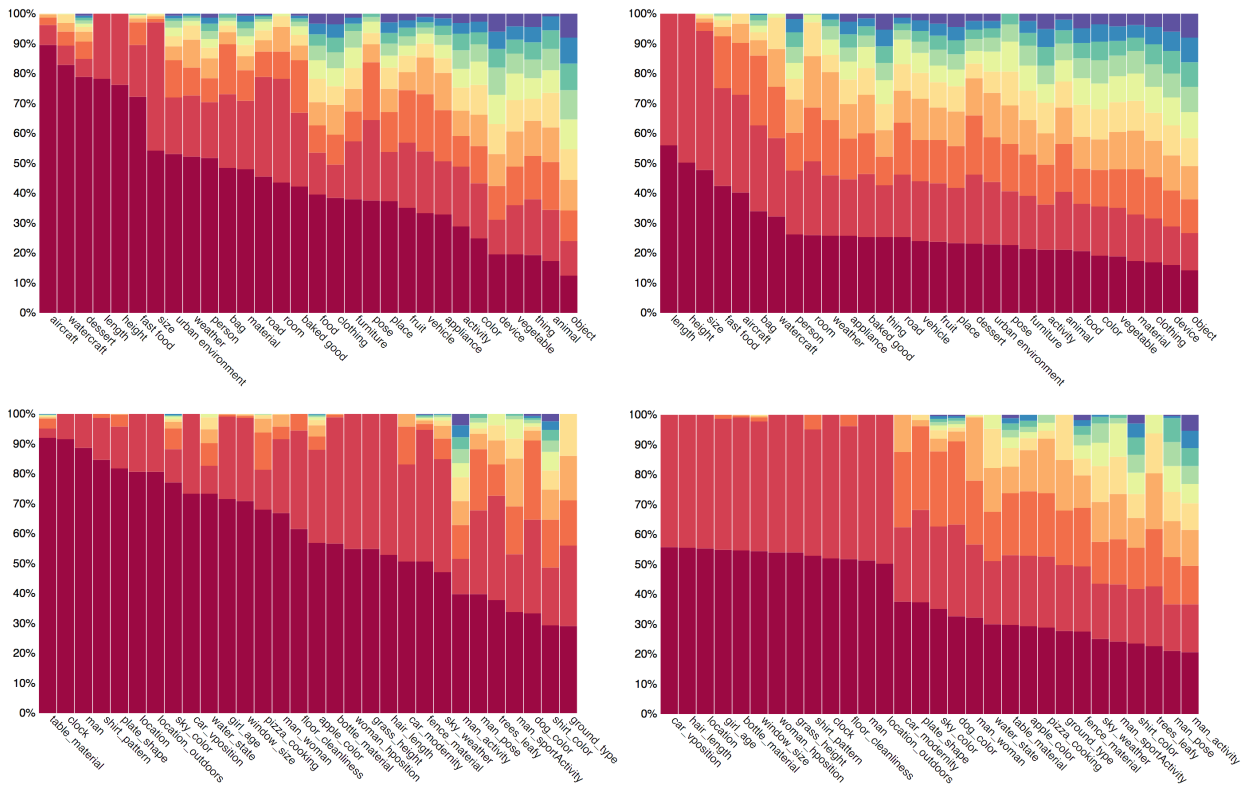

"The left side shows the distribution before any balancing. We show the top 10 answers for a selection of question groups, where the column height corresponds to the relative frequency of each answer. The top row shows global question groups such as color questions, questions about animals, etc. while the bottom row shows local ones e.g. apple-color, table-material etc (section 3.3, main paper)."

In [39]:
group_distribution(gqa_questions_balanced, "local_question_group", unambiguous_conditionals_in_paper, "unique conditionals on balanced", plot=True)

Those are the local groups mapped to unique conditionals. This should preserve the structure from above. But `06-trees_leafy` looks very different.

In [40]:
group_distribution(gqa_questions_balanced, "local_question_group", conditionals_in_paper, "conditionals on balanced", plot=True)

Here, `06-pizza_cooking` etc. is super different.

In [41]:
group_distribution(gqa_questions_balanced, "local_question_group_clean", local_question_types_in_paper, "cleaned on balanced", plot=True)

* vastly different for `man`, `car_modern`, and a lot of other labels

In [42]:
group_distribution(gqa_questions_balanced, "global_question_group", global_question_types_in_paper, gqa_datasplit="balanced", plot=True)

* `bag` (6 -> 16) is somewhere totally different, a lot of others (`room`, `weather`) also changing places... 
* `fast food` and `aircraft` are now basically on the same most frequent levels. (...) but the general picture is similar.

In [43]:
group_distribution(gqa_questions_all, "global_question_group", global_question_types_in_paper, gqa_datasplit="all", plot=True)

* `material` nearly perfectly switched with `clothing`, `applicance` with `vehicle`.

### Taking the local groups at face value

Parts before the `-` are from `getConditional()` and after the `,` are short for `subject` or `object`, I guess?

### Testing the results

## Reproducing figure 13: Semantic Steps (ReadMe: 5.)

The semantic steps were calculated with the `getStepsNum()` function from `eval.py`: Compute number of reasoning steps (excluding the final "querying" step which doesn't increase effective reasoning length). The function had to be slightly changed as a `code` field is not part of the dataset anymore.

Example Drew: "Is it sunny?" (e.g. 19945469, 07460935, 02747637, 19458959) is transitive reasoning with one step.

The function provided should change the result e.g. for question `07333408`.

In [62]:
# Compute number of reasoning steps (excluding the final "querying" step which doesn't increase effective reasoning length)
def getStepsNum(question):
    question = question.split("->")
    return len([c for c in question if not (any([o in c for o in ["exist", "query: name", "choose name"]]))])

In [65]:
# number of steps for is it sunny:
print(gqa_questions_balanced.loc["19945469"][['question_text','reasoning_operations']])
print(f"Result of getStepsNum: {getStepsNum(gqa_questions_balanced.loc['19945469']['reasoning_operations'])}")

question_text                                       Is it sunny?
reasoning_operations    select: scene->verify weather: sunny [0]
Name: 19945469, dtype: object
Result of getStepsNum: 2


In [60]:
# test the function
getStepsNum(gqa_questions_balanced.loc["07333408"]['reasoning_operations'])

select: wall (722332)->filter color: white [0]->relate: _,on,s (722335) [1]->query: name [2]
['select: wall (722332)', 'filter color: white [0]', 'relate: _,on,s (722335) [1]', 'query: name [2]']


3

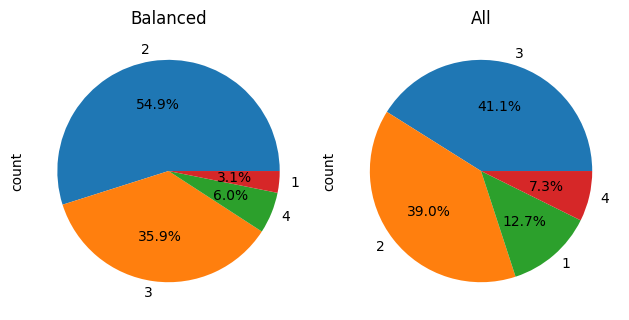

In [63]:
# use the gqa-function to compute the number of reasoning steps
gqa_questions_balanced['reasoning_steps_semantic_paper'] = gqa_questions_balanced['reasoning_operations'].apply(getStepsNum)
gqa_questions_all['reasoning_steps_semantic_paper'] = gqa_questions_all['reasoning_operations'].apply(getStepsNum)

# new dataframe
gqa_reasoning_steps_pie_balanced = gqa_questions_balanced['reasoning_steps_semantic_paper'].copy()
gqa_reasoning_steps_pie_all = gqa_questions_all['reasoning_steps_semantic_paper'].copy()

# summarize all values of 4 and above
gqa_reasoning_steps_pie_balanced.loc[gqa_reasoning_steps_pie_balanced >= 4] = 4
gqa_reasoning_steps_pie_all.loc[gqa_reasoning_steps_pie_all >= 4] = 4

# plot the pie charts
fig, axs = plt.subplots(1, 2)

gqa_reasoning_steps_pie_balanced.value_counts().plot.pie(ax=axs[0],autopct='%1.1f%%')
axs[0].set_title('Balanced')

gqa_reasoning_steps_pie_all.value_counts().plot.pie(ax=axs[1],autopct='%1.1f%%')
axs[1].set_title('All')

plt.tight_layout()
plt.savefig('results/fig13_reasoning_steps_paper.png')
fig.show()

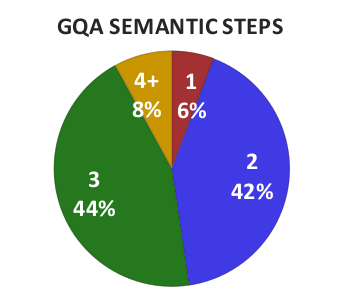

The ratios are quiet different.

* 2 steps: $6 \%$ != $28 \%$
* ...

## Reproducing table 3: Comparison of VQA and GQA (ReadMe: 6.)

Following the logic from `getWordsNum()` of `eval.py`:

In [68]:
# caluclate the mean length and std of the questions
mean_length = gqa_questions_balanced['question_length_paper'].mean()
mean_length_wo_test = gqa_questions_balanced[gqa_questions_balanced['datasplit'] != 'testdev']['question_length_paper'].mean()
std_length = gqa_questions_balanced['question_length_paper'].std()
std_length_wo_test = gqa_questions_balanced[gqa_questions_balanced['datasplit'] != 'testdev']['question_length_paper'].std()
print(f"Question length paper: {mean_length:.2f} +/- {std_length:.2f}")
print(f"Question length paper (without testdev): {mean_length_wo_test:.2f} +/- {std_length_wo_test:.2f}")

# print(f"Compositional Questions (>0): {len(gqa_questions_balanced[gqa_questions_balanced['composition_len_semantic'] > 0]) / len(gqa_questions_balanced):.2f}")
# print(f"Compositional Questions (>1): {len(gqa_questions_balanced[gqa_questions_balanced['composition_len_semantic'] > 1]) / len(gqa_questions_balanced):.2f}")
# print(f"Composition length: {gqa_questions_balanced['composition_len_semantic'].mean():.2f} +/- {gqa_questions_balanced['composition_len_semantic'].std():.2f}")

# calculate the ratio of relation, spatial, logical, comparative
gqa_questions_balanced['structural_type'].value_counts(normalize=True)

Question length paper: 8.76 +/- 3.63
Question length paper (without testdev): 8.76 +/- 3.64


structural_type
query      0.517565
verify     0.206639
choose     0.123005
logical    0.121297
compare    0.031494
Name: proportion, dtype: float64

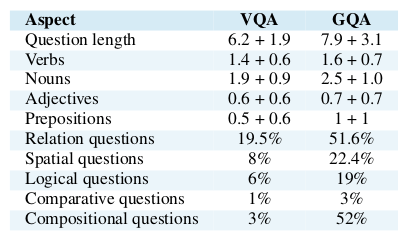

* the question length and the std is quiet different!
* how does calculating compositional questions work?
* Spatial == `verify`?
* less `logical` questions

In [70]:
# write the result above to a txt file
with open('results/tab3_comparison.txt', 'w') as f:
    f.write(f"Question length paper: {mean_length:.2f} +/- {std_length:.2f}\n")
    f.write(f"Question length paper (without testdev): {mean_length_wo_test:.2f} +/- {std_length_wo_test:.2f}\n")
    f.write(gqa_questions_balanced['structural_type'].value_counts(normalize=True).to_string())

In an earlier version of the paper, this table was significantly longer and included the following:

In [40]:
# calculate the ratio of the where-questions and the who-questions
where_questions = gqa_questions_balanced['question_text'].apply(lambda x: True if 'where' in x.lower().split()[0] else False)
print(f"The ratio of where-questions is {where_questions.sum() / len(where_questions) *100:.3f}%")
who_questions = gqa_questions_balanced['question_text'].apply(lambda x: True if 'who' in x.lower().split()[0] else False)
print(f"The ratio of who-questions is {who_questions.sum() / len(who_questions) *100:.3f}%")

print(f"Short Questions <= 5 words: {len(gqa_questions_balanced[gqa_questions_balanced['question_length'] <= 5]) / len(gqa_questions_balanced):.2f}")

The ratio of where-questions is 1.395%
The ratio of who-questions is 5.690%
Short Questions <= 5 words: 0.19
